<a href="https://colab.research.google.com/github/shinnew9/cse337-cse437RL/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [1]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 23.2 MB/s eta 0:00:00


In [2]:
import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [3]:
set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [4]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        """Stroe one transition (s, a, r, s', done) into the replay buffer."""
        idx = self.ptr % self.cap
        self.obs[idx] = s
        self.act[idx] = a
        self.nxt[idx] = sp
        self.rew[idx] = r
        self.term[idx] = term
        self.ptr += 1
        self.size = min(self.size +1, self.cap)

    def sample(self, batch):
        """Return random batch """
        assert self.size > 0
        idxs = np.random.randint(0, self.size, size=batch)
        s = self.obs[idxs]
        a = self.act[idxs]
        sp = self.nxt[idxs]
        delta_s = sp - s
        return to_t(np.concatenate([s, a], axis = -1)), to_t(delta_s)

replay = Replay(obs_dim, act_dim)


## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [5]:
def collect_random(env, replay, steps=10000, seed=42, render=False):
    """Collect random experience tuples (s, a, r, s', done) and store in replay buff"""
    np.random.seed(seed)
    obs, _ = env.reset(seed=seed)
    total_steps = 0
    ep_returns = []
    ep_ret = 0

    while total_steps < steps:
      # sample random action uniformly from action space
      a = np.random.uniform(env.action_space.low, env.action_space.high)

      # step environment
      next_obs, r, done, trunc, info = env.step(a)

      # store in replay buffer
      replay.add(obs, a, r, next_obs, float(done or trunc))

      ep_ret += r
      total_steps += 1
      obs = next_obs

      # handle episode termination
      if done or trunc:
        obs, _ = env.reset()
        ep_returns.append(ep_ret)
        ep_ret = 0

      # optional rendeirng for debug
      if render and total_steps % 2000 == 0:
        env.render()

    print(f" Collected {replay.size} transitions over {len(ep_returns)} epsisodes.")
    print(f" Average episodic return (random policy): {np.mean(ep_returns):.2f}")

In [6]:
set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

replay = Replay(obs_dim, act_dim)

# Collect random data
collect_random(env, replay, steps=100000)

# Check buffer contents
print("Replay buffer size:", replay.size)
x, y = replay.sample(5)
print("Sample x shape:", x.shape, "y shape:", y.shape)

 Collected 100000 transitions over 100 epsisodes.
 Average episodic return (random policy): -291.06
Replay buffer size: 100000
Sample x shape: torch.Size([5, 23]) y shape: torch.Size([5, 17])



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [7]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    pass

update_normalizers_from_buffer(replay)
print("Normalizers ready.")

Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [8]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)


## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



In [9]:
def train_model(model, replay, epochs=30, batch_size=256):
    model.train()
    losses = []

    # 전역으로 정의된 옵티마이저/스케줄러 사용 (이전 블록 파라미터 유지)
    global opt, scheduler

    mse = nn.MSELoss(reduction='mean')

    for ep in range(epochs):
        epoch_loss = 0.0
        num_batches = max(1, int(np.ceil(replay.size / batch_size)))

        for _ in range(num_batches):
            # 1) 샘플링: x = [s,a], y = Δs  (현재는 torch tensor 반환)
            x_t, y_t = replay.sample(batch_size)          # shapes: (B, obs+act), (B, obs)

            # 2) 정규화: RunningNormalizer는 numpy 입력을 기대하므로 왕복 변환
            x_np = x_t.cpu().numpy()
            y_np = y_t.cpu().numpy()
            xn_np = inp_norm.normalize(x_np)
            yn_np = targ_norm.normalize(y_np)

            xn = to_t(xn_np)
            yn = to_t(yn_np)

            # 3) forward / loss
            pred = model(xn)               # 예측: normalized Δs
            loss = mse(pred, yn)

            # 4) backward
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += float(loss.item())

        # 5) 스케줄러로 학습률 감소
        scheduler.step()

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        # 학습률 모니터링
        lr_now = opt.param_groups[0]['lr']
        print(f"Epoch {ep+1:02d}/{epochs} | lr={lr_now:.6f} | train MSE={avg_loss:.6f}")

    return losses

Epoch 01/30 | lr=0.000800 | train MSE=5.639110
Epoch 02/30 | lr=0.000640 | train MSE=1.257424
Epoch 03/30 | lr=0.000512 | train MSE=1.135372
Epoch 04/30 | lr=0.000410 | train MSE=1.061508
Epoch 05/30 | lr=0.000328 | train MSE=1.018000
Epoch 06/30 | lr=0.000262 | train MSE=0.978671
Epoch 07/30 | lr=0.000210 | train MSE=0.969386
Epoch 08/30 | lr=0.000168 | train MSE=0.950070
Epoch 09/30 | lr=0.000134 | train MSE=0.933416
Epoch 10/30 | lr=0.000107 | train MSE=0.916104
Epoch 11/30 | lr=0.000086 | train MSE=0.909103
Epoch 12/30 | lr=0.000069 | train MSE=0.908666
Epoch 13/30 | lr=0.000055 | train MSE=0.898278
Epoch 14/30 | lr=0.000044 | train MSE=0.890411
Epoch 15/30 | lr=0.000035 | train MSE=0.886814
Epoch 16/30 | lr=0.000028 | train MSE=0.892029
Epoch 17/30 | lr=0.000023 | train MSE=0.883618
Epoch 18/30 | lr=0.000018 | train MSE=0.883361
Epoch 19/30 | lr=0.000014 | train MSE=0.881120
Epoch 20/30 | lr=0.000012 | train MSE=0.876912
Epoch 21/30 | lr=0.000009 | train MSE=0.875983
Epoch 22/30 |

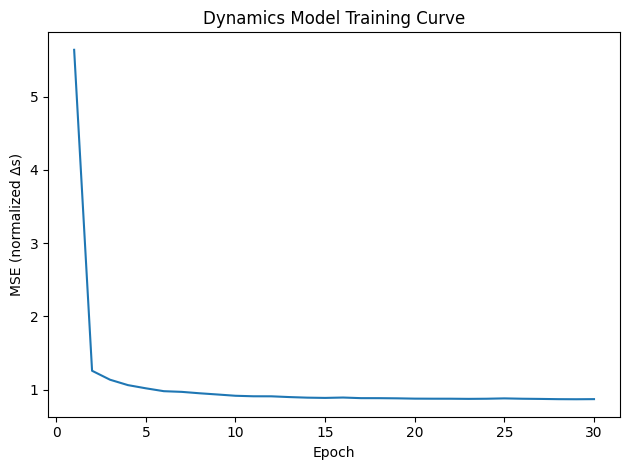

In [10]:
losses = train_model(model, replay, epochs=30, batch_size=256)

plt.figure()
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Dynamics Model Training Curve")
plt.tight_layout()
plt.show()

## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [17]:
# A. Collect a fresh held-out set (unseen) ---

def collect_validation_set(env, n_transitions=5000, seed=123):
  rng = np.random.RandomState(seed)
  obs, _ = env.reset(seed=seed)
  S, A, SP = [], [], []
  while len(S) < n_transitions:
    a = rng.uniform(env.action_space.low, env.action_space.high)
    sp, r, done, trunc, info = env.step(a)
    S.append(obs.copy())
    A.append(a.copy())
    SP.append(sp.copy())
    obs = sp
    if done or trunc:
      obs, _ = env.reset()
  S, A, SP = np.array(S, dtype=np.float32), np.array(A, dtype=np.float32), np.array(SP, dtype=np.float32)
  return S, A, SP

S_val, A_val, SP_val = collect_validation_set(env, n_transitions=5000, seed=123)

# B. One-Step MSE (normalized & unnormalized)
@th.no_grad()
def one_step_mse(model, S, A, SP):
  model.eval()
  ΔS_true = SP - S

  # normalize inputs & targets
  Xn = inp_norm.normalize(np.concatenate([S, A], axis=-1))
  Yn = targ_norm.normalize(ΔS_true)

  # predict normalized ΔS
  pred_n = model(to_t(Xn)).cpu().numpy()

  # MSE in normalized spcace
  mse_norm = float(np.mean((pred_n - Yn)**2))

  # denormalize prediction and compute MSE in raw space
  pred_raw = targ_norm.denormalize(pred_n)
  mse_raw = float(np.mean((pred_raw - ΔS_true)**2))
  return mse_norm, mse_raw

mse1_norm, mse1_raw = one_step_mse(model, S_val, A_val, SP_val)
print(f"One-step MSE (normalized): {mse1_norm:.4f}")
print(f"One-step MSE (raw ΔS): {mse1_raw:.6f}")

One-step MSE (normalized): 0.8074
One-step MSE (raw ΔS): 0.807436


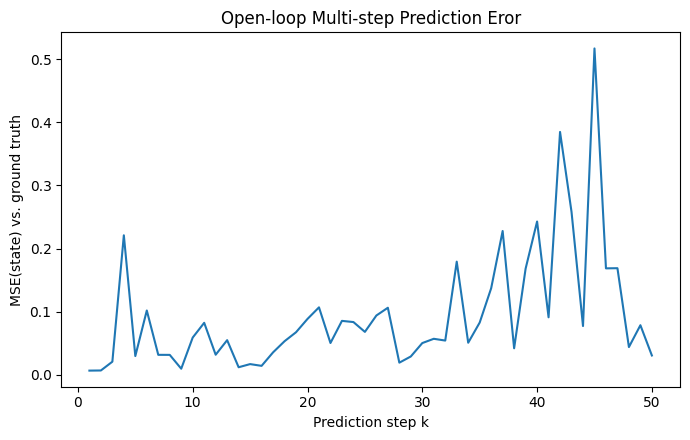

In [25]:
# Openloop K-step Prediction error (Model vs Real Environment)
@th.no_grad()
def open_loop_rollout_error(model, env, horizon=50, episodes=20, seed=2024):
  rng = np.random.RandomState(seed)
  model.eval()
  act_low, act_high = env.action_space.low, env.action_space.high

  # 누적 error (Average MSe per steps)을 담은 buffer
  errs = np.zeros(horizon, dtype=np.float64)

  for ep in range(episodes):
    obs_true, _ = env.reset(seed=seed + ep)
    obs_model = obs_true.copy()

    for t in range(horizon):
      a = rng.uniform(act_low, act_high)

      # real env step
      next_true, r, done, trunc, info = env.step(a)

      # model step(use learned Δs; do NOT advance env)
      x_in = np.concatenate([obs_model, a], axis=-1)[None, :]
      x_in_n = inp_norm.normalize(x_in)
      Δs_pred_n = model(to_t(x_in_n)).cpu().numpy()
      Δs_pred = targ_norm.denormalize(Δs_pred_n)[0]
      next_model = obs_model + Δs_pred

      # step-t error
      errs[t] += np.mean((next_model - next_true)**2)

      # advance both states
      obs_true = next_true
      obs_model = next_model

      if done or trunc:       # when the episodes are over, the model resets and restart
        obs_true, _ = env.reset(seed = seed + ep + t + 1)
        obs_model = obs_true.copy()

    errs /= episodes
    return errs

errs = open_loop_rollout_error(model, env, horizon=50, episodes=20, seed=2024)

# plot: prediciton error growth vs step
plt.figure(figsize=(7, 4.5))
plt.plot(np.arange(1, len(errs)+1), errs)
plt.xlabel("Prediction step k")
plt.ylabel("MSE(state) vs. ground truth")
plt.title("Open-loop Multi-step Prediction Eror")
plt.tight_layout()
plt.show()


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



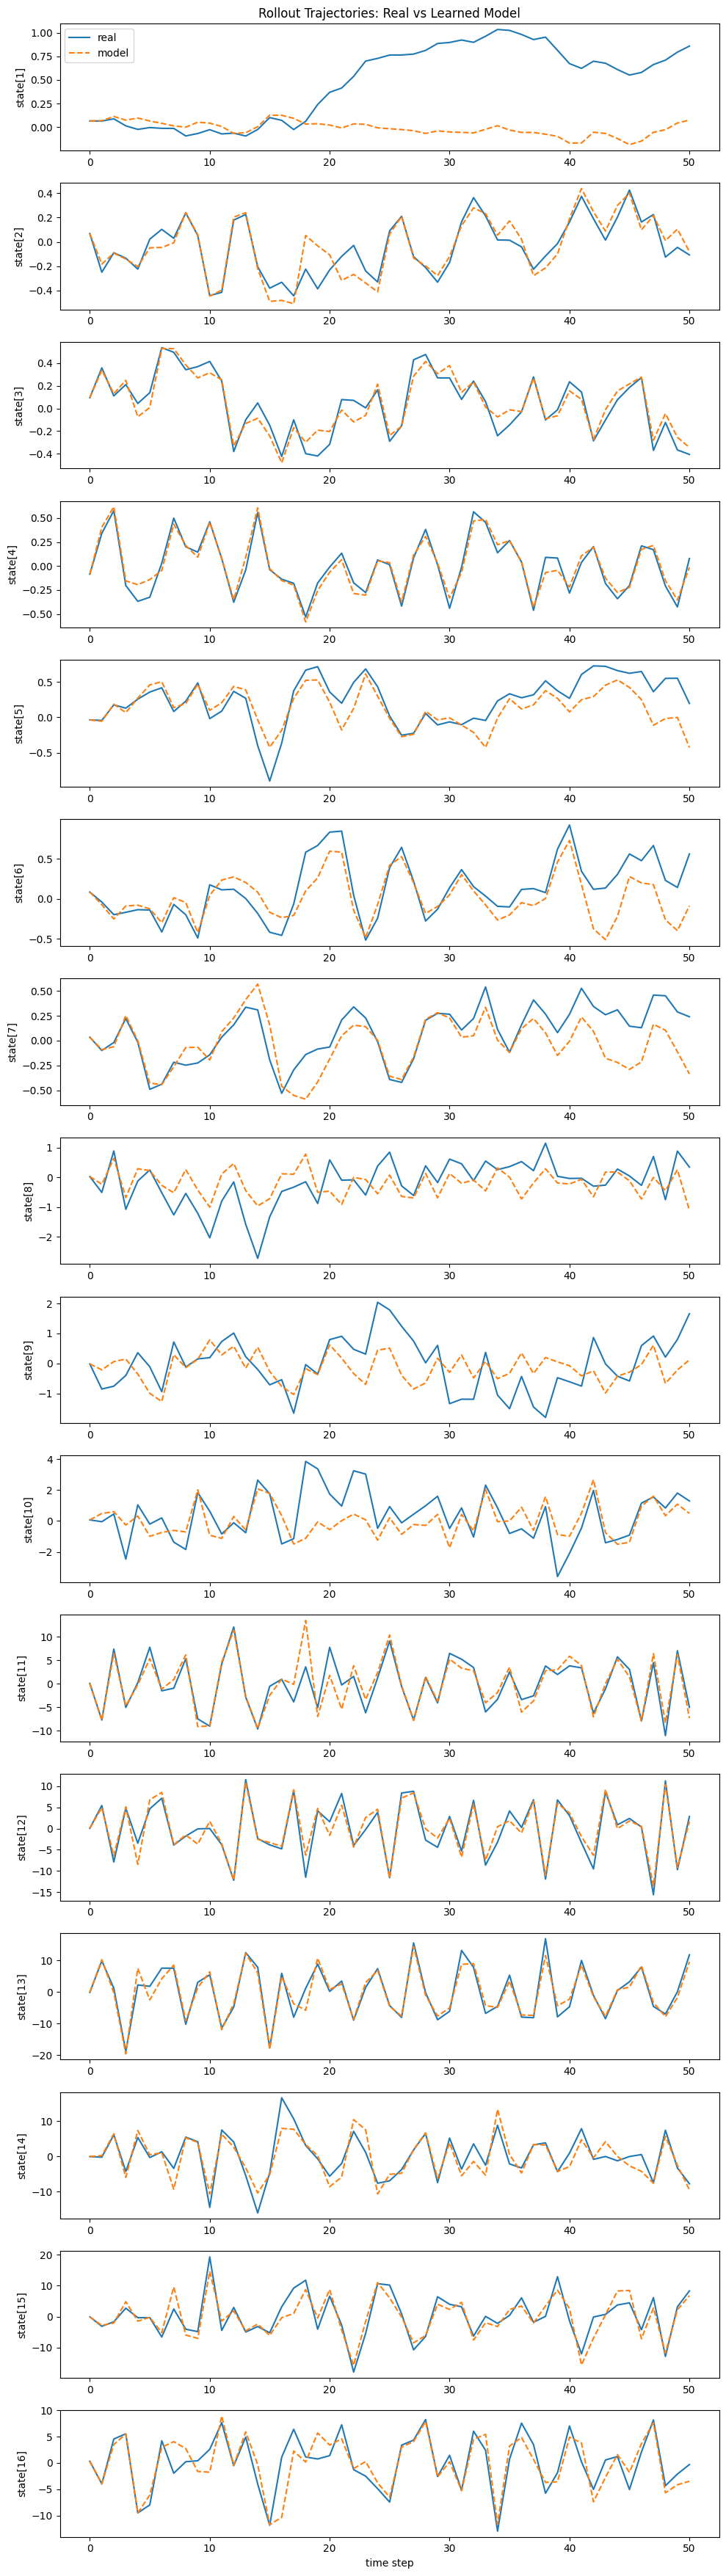

In [27]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    """
    Visualize real env vs learned-dynamics rollout under the same action sequence.
      - k: number of actions to roll
      - dims: iterable of state indices to plot
    """

    model.eval()
    rng = np.random.RandomState(seed)

    # Reset & keep initial state
    obs, _ = env.reset(seed=seed)
    real_traj = [obs.copy()]
    model_traj = [obs.copy()]

    # Pre-sample actions so both paths see the same sequence
    actions = [rng.uniform(env.action_space.low, env.action_space.high) for _ in range(k)]

    # Roll forward
    for a in actions:
      # real env
      sp, r, done, trunc, info = env.step(a)
      real_traj.append(sp.copy())

      # model rollout (open-loop, no env call)
      s_model = model_traj[-1]
      xin = np.concatenate([s_model, a], axis=-1)[None, :]
      xin_n = inp_norm.normalize(xin)
      with th.no_grad():
        dnorm = model(to_t(xin_n)).cpu().numpy()
      draw = targ_norm.denormalize(dnorm)[0]
      s_next_model = s_model + draw
      model_traj.append(s_next_model)

      if done or trunc:
        break

    real_traj = np.array(real_traj)
    model_traj = np.array(model_traj)


    # Plot
    D = len(dims)
    plt.figure(figsize=(10, max(3, 2.2*D)))
    T = np.arange(real_traj.shape[0])

    for i, d in enumerate(dims, start=1):
      plt.subplot(D, 1, i)
      plt.plot(T, real_traj[:, d], label="real")
      plt.plot(T, model_traj[:len(T), d], "--", label="model")
      plt.ylabel(f"state[{d}]")
      if i == 1:
        plt.title("Rollout Trajectories: Real vs Learned Model")
        plt.legend()
      if i == D:
        plt.xlabel("time step")

    plt.tight_layout()
    plt.show()



# Uncomment to visualize
dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims, seed=2025)#(qvel_start, qvel_start+1, qvel_start+2))


## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



##Answers

Q1: How good is your model?
<br>
<br>
The learned dynamics model performs quite well for short-horizon predictions.
In one-step rollouts, the MSE is low and the model captures the main structure of HalfCheetah’s motion.
However, in multi-step (open-loop) rollouts, the prediction error grows with time because small local errors compound.
This behavior is expected — the model approximates the physics locally, not globally — but overall, it shows that the network has learned a reasonable approximation of the true dynamics.

<br>
<br>

Q2: Is this training enough for planning, or do we need continual training?
<br>
<br>
This offline training is not enough for long-term planning.
The random rollouts only cover a limited portion of the state–action space, so the model’s accuracy will degrade when the agent explores unseen regions.
In practice, model-based control systems use continual training or online model updates, where new experience is collected during interaction and the model is periodically re-trained.
This keeps the dynamics model consistent with the agent’s evolving policy and improves long-term performance.

<br>
<br>

Q3: How is this system different from the Mountain Car problem? Why can’t we learn this in one episode?
<br>
<br>
The Mountain Car environment is low-dimensional (2 states, 1 action) and has simple, known dynamics.
In contrast, HalfCheetah has 17-dimensional states and 6-dimensional continuous actions, with complex nonlinear physics and contact dynamics.
Because of this high dimensionality and stochasticity, a single episode cannot provide enough coverage to learn the full transition model.
We need many trajectories from different states to generalize across diverse motion patterns and joint configurations.

<br>
<br>

Q4: Why do we use a RunningNormalizer instead of a static normalizer?
<br>
<br>
We use a RunningNormalizer because model-based learning often happens online or iteratively —
the replay buffer grows over time as new data arrives.
Unlike a static normalizer (which assumes a fixed dataset), a running normalizer updates the mean and variance incrementally,
allowing the normalization statistics to adapt as the distribution of states and actions changes.
This is consistent with the model-based RL algorithms taught in class,
where the agent continually gathers new experience and refines both its dynamics model and normalization parameters on the fly.
